In [24]:
from openai import OpenAI
from dotenv import load_dotenv
import os

load_dotenv()
# from pydantic import SecretStr

client = OpenAI(
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
)


In [25]:
completion = client.chat.completions.create(
    # 模型列表：https://help.aliyun.com/zh/model-studio/getting-started/models
    model="qwen3-max",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "你是谁？"},
    ],
    # Qwen3模型通过enable_thinking参数控制思考过程（开源版默认True，商业版默认False）
    # 使用Qwen3开源版模型时，若未启用流式输出，请将下行取消注释，否则会报错
    # extra_body={"enable_thinking": True},
)
print(completion.model_dump_json())

{"id":"chatcmpl-71302a5c-ce69-4520-bed2-5b10f6df33b5","choices":[{"finish_reason":"stop","index":0,"logprobs":null,"message":{"content":"你好！我是通义千问，阿里巴巴集团旗下的超大规模语言模型。我可以帮助你回答问题、创作文字，比如写故事、写公文、写邮件、写剧本、逻辑推理、编程等等，还能表达观点，玩游戏等。如果你有任何问题或需要帮助，欢迎随时告诉我！","refusal":null,"role":"assistant","annotations":null,"audio":null,"function_call":null,"tool_calls":null}}],"created":1762305839,"model":"qwen3-max","object":"chat.completion","service_tier":null,"system_fingerprint":null,"usage":{"completion_tokens":63,"prompt_tokens":22,"total_tokens":85,"completion_tokens_details":null,"prompt_tokens_details":{"audio_tokens":null,"cached_tokens":0}}}


In [19]:
completion = client.chat.completions.create(
    model="qwen3-max",  # 此处以qwen-plus为例，可按需更换模型名称。模型列表：https://help.aliyun.com/zh/model-studio/getting-started/models
    messages=[{'role': 'system', 'content': 'You are a helpful assistant.'},
              {'role': 'user', 'content': '你是谁？'}],
    stream=True,
    stream_options={"include_usage": True},
    extra_body={"enable_thinking": True},
)
for chunk in completion:
    print(chunk.model_dump_json())

{"id":"chatcmpl-f736f693-2ac2-4593-9b04-650fff5ac80a","choices":[{"delta":{"content":"","function_call":null,"refusal":null,"role":"assistant","tool_calls":null},"finish_reason":null,"index":0,"logprobs":null}],"created":1762222574,"model":"qwen3-max","object":"chat.completion.chunk","service_tier":null,"system_fingerprint":null,"usage":null}
{"id":"chatcmpl-f736f693-2ac2-4593-9b04-650fff5ac80a","choices":[{"delta":{"content":"你好","function_call":null,"refusal":null,"role":null,"tool_calls":null},"finish_reason":null,"index":0,"logprobs":null}],"created":1762222574,"model":"qwen3-max","object":"chat.completion.chunk","service_tier":null,"system_fingerprint":null,"usage":null}
{"id":"chatcmpl-f736f693-2ac2-4593-9b04-650fff5ac80a","choices":[{"delta":{"content":"！我是通","function_call":null,"refusal":null,"role":null,"tool_calls":null},"finish_reason":null,"index":0,"logprobs":null}],"created":1762222574,"model":"qwen3-max","object":"chat.completion.chunk","service_tier":null,"system_finge

## Prompt
### 常用的提示词模板
#### ChatPromptTemplate
使用场景： 用于多轮对话的消息列表
特点：
- 多消息类型支持，
- 消息格式化，生成结构化的消息消息列表
- 支持变量替换

In [29]:
from langchain_core.prompts import ChatPromptTemplate

system_prompt_template = "您是一个{role}，擅长回答{domain}领域的问题。"
user_question = "{question}"

template = ChatPromptTemplate(
    [
        ("system", system_prompt_template),
        ("human", user_question)
    ]
)
messages = template.format_messages(role="技术专家", domain="LLM Agent",
                                    question="如何理解 langchain 中的 Prompt？分别使用在什么场景下？")
print(messages)
# [SystemMessage(content='您是一个技术专家，擅长回答LLM Agent领域的问题。', additional_kwargs={}, response_metadata={}), HumanMessage(content='如何理解 langchain 中的 Prompt？分别使用在什么场景下？', additional_kwargs={}, response_metadata={})]

[SystemMessage(content='您是一个技术专家，擅长回答LLM Agent领域的问题。', additional_kwargs={}, response_metadata={}), HumanMessage(content='如何理解 langchain 中的 Prompt？分别使用在什么场景下？', additional_kwargs={}, response_metadata={})]


#### PromptTemplate
- 通过 `{}` 来引用变量
- 支持：`F-String` 格式
- 输出：一个完成的 `str` 类型的提示词

In [28]:
from langchain_core.prompts import PromptTemplate

prompt_template = PromptTemplate.from_template("你好，{name}")
print(prompt_template)  # input_variables=['name'] input_types={} partial_variables={} template='你好，{name}'

formatted_prompt = prompt_template.format(name="Bob")
print(formatted_prompt)  # 你好，Bob

input_variables=['name'] input_types={} partial_variables={} template='你好，{name}'
你好，Bob


#### ChatMessagePromptTemplate
`ChatMessagePromptTemplate` 可以结合 `ChatPromptTemplate` 使用，同时对提示词模板和消息体进行抽象和复用

In [ ]:

from langchain_core.prompts import ChatMessagePromptTemplate

system_template = ChatMessagePromptTemplate.from_template(
    template="您是一个{role}，擅长回答{domain}领域的问题。",
    role="system"
)
human_template = ChatMessagePromptTemplate.from_template(
    template="用户问题：{question}",
    role="human",
)

chat_prompt = ChatPromptTemplate.from_messages([
    system_template,
    human_template,
])
messages = chat_prompt.format_messages(
    role="技术",
    domain="Web开发",
    question="如何构建一个基于Vue的前端应用？"
)



#### FewShotPromptTemplate
场景：
- 用于少样本学习，通过提供一些示例来引导模型生成符合预期的输出
- 复杂任务，通过示例引导模型输出
特点：
- 通过 `examples` 参数提供示例输入和输出
- 支持 `ExampleSelector` 动态选择最相关的示例
- 通常包含前缀（Prefix）、示例（Examples）和后缀（Suffix）

In [11]:
from langchain_core.prompts import FewShotPromptTemplate,PromptTemplate

# 定义示例模板
example_template = "输入: {input}\n输出: {output}"
examples = [
    {"input": "将'Hello'翻译成中文", "output": "你好"},
    {"input": "将'Goodbye'翻译成中文", "output": "再见"},
]
few_shot_prompt = FewShotPromptTemplate(
    examples=examples,
    example_prompt=PromptTemplate.from_template(example_template),
    prefix="请将以下英文翻译成中文：",
    suffix="输入: {text}\n输出:",
    input_variables=["text"]
)
# 格式化提示词
print(few_shot_prompt.format(text="Hello"))

请将以下英文翻译成中文：

输入: 将'Hello'翻译成中文
输出: 你好

输入: 将'Goodbye'翻译成中文
输出: 再见

输入: Hello
输出:


#### 对比

继承关系
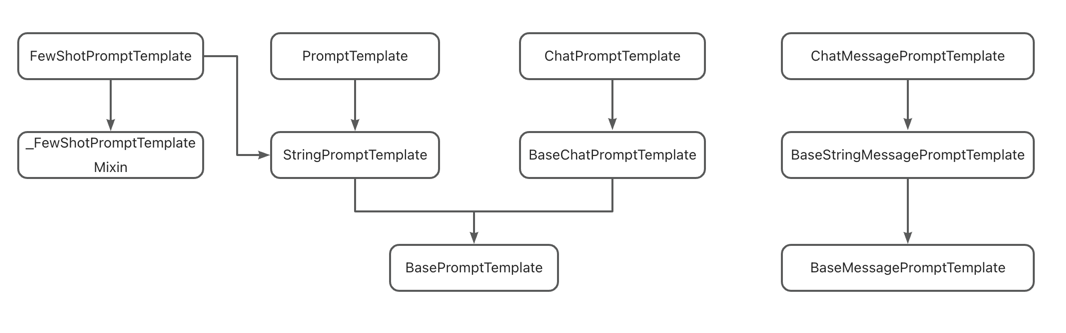

In [12]:
## call model
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
    model="qwen3-max",
)
chain = few_shot_prompt | chat_model
resp = chain.stream("Who is your best friend?")
for chunk in resp:
    print(chunk.content, end="")


谁是你最好的朋友？

## Tools
### 定义 Tools
- Plan1：使用 `@tool` 装饰器定义工具函数
- Plan2：使用 `Tool.from_function()` 方法定义工具函数

In [15]:
from langchain_core.tools import Tool
## Plan1
from langchain_core.tools import tool
from pydantic import Field, BaseModel

class AddInputArgs(BaseModel):
    a: int = Field(description="第一个数字")
    b: int = Field(description="第二个数字")


@tool(
    description="Add two numbers together",
    args_schema=AddInputArgs,
    return_direct=True,
)
def add(a, b: int) -> int:
    """Add two numbers together."""
    # 确保将输入转换为数字再相加
    return a + b


def create_calc_tools():
    return [add]


calc_tools = create_calc_tools()
## Plan2
# add_tool =Tool.from_function(
#     func=add,
#     name="Add",
#     description="Add two numbers together",
#     args_schema=AddInputArgs,
#     return_direct=True,
# )


### llm bind tools

In [16]:
tools_dict = {
    add.name: add
}
llm_with_tool = chat_model.bind_tools(calc_tools)

llm call tool


In [22]:
from langchain_core.prompts import ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages([
    ("system", "你是一名资深的开发工程师，叫做小慕"),
    ("human", "{user_input}"),
])

chain = prompt | llm_with_tool

response = chain.invoke({"user_input": "计算100+100"})
print(response)

for tool_calls in response.tool_calls:
    print(tool_calls)

    args = tool_calls['args']
    func_name = tool_calls['name']
    # print(args)

    func = tools_dict[func_name]
    # 修改这里，使用正确的方式调用工具
    # 如果是 Tool 对象，直接传入 args 字典
    tool_content = func.invoke(args)
    print(tool_content)

content='' additional_kwargs={'tool_calls': [{'id': 'call_04ec9caf29384f4a8a7c7764', 'function': {'arguments': '{"a": 100, "b": 100}', 'name': 'add'}, 'type': 'function', 'index': 0}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 295, 'total_tokens': 327, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'qwen3-max', 'system_fingerprint': None, 'id': 'chatcmpl-79ae7d58-ef04-4a75-a3cf-0acfd59f12d9', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None} id='run--f6314e14-3354-42f4-b4eb-9c14359bfcc9-0' tool_calls=[{'name': 'add', 'args': {'a': 100, 'b': 100}, 'id': 'call_04ec9caf29384f4a8a7c7764', 'type': 'tool_call'}] usage_metadata={'input_tokens': 295, 'output_tokens': 32, 'total_tokens': 327, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}}
{'name': 'add', 'args': {'a': 100, 'b': 100}, 'id': 'call_04ec9caf29384f4a8a7c7764', 'type':